# LSTM Time Series AutoEncoding
* https://machinelearningmastery.com/lstm-autoencoders/

In [1]:
N_STOCK = 112
SEED = 1111

In [2]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import glob
import os
import gc
import datetime
import pickle

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
pd.set_option('display.max_columns', None)

In [3]:
# df = pd.DataFrame({'a':[1,2,3,4,5], 'b':['a','a','b','b','c']})
# df.groupby('b')['a'].agg(lambda s:s.max()-s.min())

In [4]:
# function to load a book/trade train/test single stock file
def load_single_stock(stock_id, train_test, book_trade):
    path = f'/kaggle/input/optiver-realized-volatility-prediction/{book_trade}_{train_test}.parquet/stock_id={str(stock_id)}'
    filename = os.path.join(path, os.listdir(path)[0])
    return pd.read_parquet(filename)

def preprocess_single_stock(stock_id, train_test, n_time_id_sample, seconds_sample_interval):
    # load data
    book = load_single_stock(stock_id, train_test, 'book')
    trade = load_single_stock(stock_id, train_test, 'trade')
    # ffill and bfill
    time_id_list =  pd.DataFrame({'time_id':book.time_id.unique().tolist()})
    seconds_in_bucket_list = pd.DataFrame({'seconds_in_bucket':range(600)})
    base = time_id_list.merge(seconds_in_bucket_list, how='cross')
    book = base.merge(book, how='left', on=['time_id','seconds_in_bucket'])
    book = book.ffill().bfill()
    trade = base.merge(trade, how='left', on=['time_id','seconds_in_bucket'])
    trade[['price']] = trade[['price']].ffill().bfill()
    trade[['size','order_count']] = trade[['size','order_count']].fillna(0)
    # joining book and trade
    df = pd.merge(book, trade, how='inner', on=['time_id','seconds_in_bucket'])
    # sampling time_id
    if n_time_id_sample >= 0:
        time_id_samples = random.sample(df['time_id'].unique().tolist(), n_time_id_sample)
        df = df[df.time_id.isin(time_id_samples)]
    # smoothing all time series
    ts = [c for c in df if c not in ['time_id','seconds_in_bucket']]
    for c in ts:
        df[c] = df.groupby('time_id')[c].apply(lambda s: s.rolling(window=50).mean())
    # seconds interval filtering
    idx = df.index.tolist()[::seconds_sample_interval]
    df = df.iloc[idx,:]
    # remove NA entries due to moving average
    df = df[df.isnull().sum(axis=1)==0].reset_index(drop=True)
    # select only relevant columns
    df['stock_id'] = stock_id
    df = df[['stock_id'] + [c for c in df if c not in ['stock_id']]]
    df = df.drop('seconds_in_bucket', axis=1)
    return df

def preprocess_all_stocks(n_stock, train_test, n_time_id_sample, seconds_sample_interval, reduce_mem):
    stock_list = sorted([int(x.split('=')[1]) for x in os.listdir(f'/kaggle/input/optiver-realized-volatility-prediction/book_{train_test}.parquet')])
    stock_list = stock_list[:n_stock]
    df = []
    for stock_id in stock_list:
        df.append(preprocess_single_stock(stock_id, train_test, n_time_id_sample, seconds_sample_interval))
        if stock_list.index(stock_id) % 10 == 0:
            print(f'[{datetime.datetime.now()}] Processed {stock_list.index(stock_id) % 10} stock_ids')
    df = pd.concat(df, axis=0).reset_index(drop=True)
    print(f'[{datetime.datetime.now()}] Completed data preprocessing')
    
    # scaling
    num_feats = [c for c in df if c not in ['stock_id','time_id']]
    scalers = {}
    for c in num_feats:
        scaler = StandardScaler().fit(df[[c]])
        df[[c]] = scaler.transform(df[[c]])
        scalers[c] = scaler
        print(f'[{datetime.datetime.now()}] Scaled {c}')
    pickle.dump(scalers, open(f'ts_ae_stdscalers.p', 'wb'))
    print(f'[{datetime.datetime.now()}] Completed data scaling')
    
    # memory reduction
    if reduce_mem==True:
        df = reduce_mem_usage(df)
        print(f'[{datetime.datetime.now()}] Completed memory reduction')
    
    # save data
    df.to_feather('ts_ae_data.f')
    return df

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
%%time

# create dataset
# data = preprocess_all_stocks(n_stock=N_STOCK, train_test='train', n_time_id_sample=-1, seconds_sample_interval=10, reduce_mem=True)
data = pd.read_feather('/kaggle/input/volatility-time-series-autoencoder-data/ts_ae_data.f')
print(f'[{datetime.datetime.now()}] Completed data preprocessing')

# train test split
from sklearn.model_selection import train_test_split
time_id_list = data[['time_id']].drop_duplicates()
time_id_train, time_id_test, _, _ = train_test_split(time_id_list, time_id_list, test_size=0.2, random_state=SEED)
X_train, X_test = data[data.time_id.isin(time_id_train.time_id)].reset_index(drop=True), data[data.time_id.isin(time_id_test.time_id)].reset_index(drop=True)
print(f'[{datetime.datetime.now()}] Completed train test split')

del data
gc.collect()

# convert to np array
X_train_keys = X_train[['stock_id','time_id']].drop_duplicates()
n_split = X_train_keys.shape[0]
X_train = np.array(np.split(X_train.iloc[:,2:].values, n_split))
print(f'Shape of X_train is {X_train.shape}')
X_test_keys = X_test[['stock_id','time_id']].drop_duplicates()
n_split = X_test_keys.shape[0]
X_test = np.array(np.split(X_test.iloc[:,2:].values, n_split))
print(f'Shape of X_test is {X_test.shape}')

[2021-09-21 18:05:00.930182] Completed data preprocessing
[2021-09-21 18:05:03.627979] Completed train test split
Shape of X_train is (343143, 55, 11)
Shape of X_test is (85789, 55, 11)
CPU times: user 5.72 s, sys: 3.59 s, total: 9.31 s
Wall time: 16.4 s


In [7]:
%%time
from keras import metrics
import keras
import tensorflow as tf
import os
from numpy.random import seed
from keras.models import Model
from keras.utils import plot_model

# parameters
epochs = 600
batch_size = 512
window_length = 55
n_feats = 11
encoding_dim = 16
seed(SEED)
tf.random.set_seed(SEED)

# callback functions
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=0, mode='min')
check_point = tf.keras.callbacks.ModelCheckpoint(filepath='tsae_best_model', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

# construct model
model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, n_feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(encoding_dim, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(encoding_dim, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(n_feats)))
model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())

# model training
model.fit(x=X_train, y=X_train, 
          validation_data=(X_test, X_test), 
          epochs=epochs, 
          batch_size=batch_size, 
          shuffle=True, 
          callbacks=[early_stop, plateau])
print(f'[{datetime.datetime.now()}] Completed model training')

# create final encoder as taking only the encoder part from the AE
ts_encoder = Model(inputs=model.inputs, outputs=model.layers[2].output)
plot_model(ts_encoder, show_shapes=True, to_file='lstm_encoder.png')

# train set encoding
X_train_keys[[f'ts_ae{i}' for i in range(encoding_dim)]] = ts_encoder.predict(X_train)
print(f'Shape of train encoding is {X_train_keys.iloc[:,2:].shape}')

# test set encoding
X_test_keys[[f'ts_ae{i}' for i in range(encoding_dim)]] = ts_encoder.predict(X_test)
print(f'Shape of test encoding is {X_test_keys.iloc[:,2:].shape}')

# combine train and test into original full dataset
data_encoded = pd.concat([X_train_keys, X_test_keys], axis=0).sort_values(['stock_id','time_id']).reset_index(drop=True)
data_encoded.to_csv('train_encoded.csv', index=False)
del X_train_keys, X_test_keys, data_encoded
gc.collect()

# save model
model.save(f'TimeSeries_AutoEncoder')
ts_encoder.save(f'TimeSeries_Encoder')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (LSTM)             (None, 55, 64)            19456     
_________________________________________________________________
encoder_2 (LSTM)             (None, 55, 32)            12416     
_________________________________________________________________
encoder_3 (LSTM)             (None, 16)                3136      
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 55, 16)            0         
_________________________________________________________________
decoder_1 (LSTM)             (None, 55, 16)            2112      
_________________________________________________________________
decoder_2 (LSTM)             (None, 55, 32)            6272      
_________________________________________________________________
decoder_3 (LSTM)             (None, 55, 64)            2

CPU times: user 1min 39s, sys: 6.08 s, total: 1min 45s
Wall time: 1min 25s


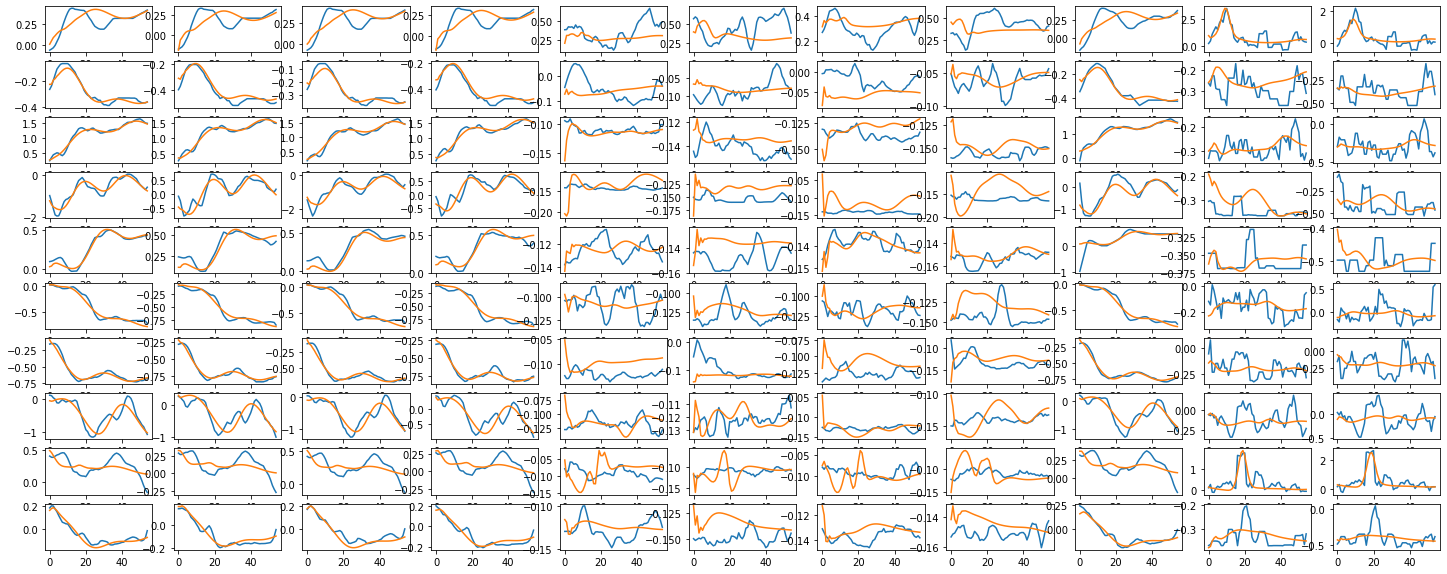

In [8]:
%%time
# sample input vs output to check if the AutoEncoder can reconstruct the input sequence
# train set prediction
import random
train_pred = model.predict(X_train)
sample_ids = random.sample(range(X_train.shape[0]), 10)
fig, axs = plt.subplots(len(sample_ids), X_train.shape[2], figsize=(25,10))
for i in range(len(sample_ids)):
    for c in range(X_train.shape[2]):
        y_true = X_train[sample_ids[i]][:,c]
        y_pred = train_pred[sample_ids[i]][:,c]
        axs[i,c].plot(y_true)
        axs[i,c].plot(y_pred)

CPU times: user 26.3 s, sys: 1.4 s, total: 27.7 s
Wall time: 22.9 s


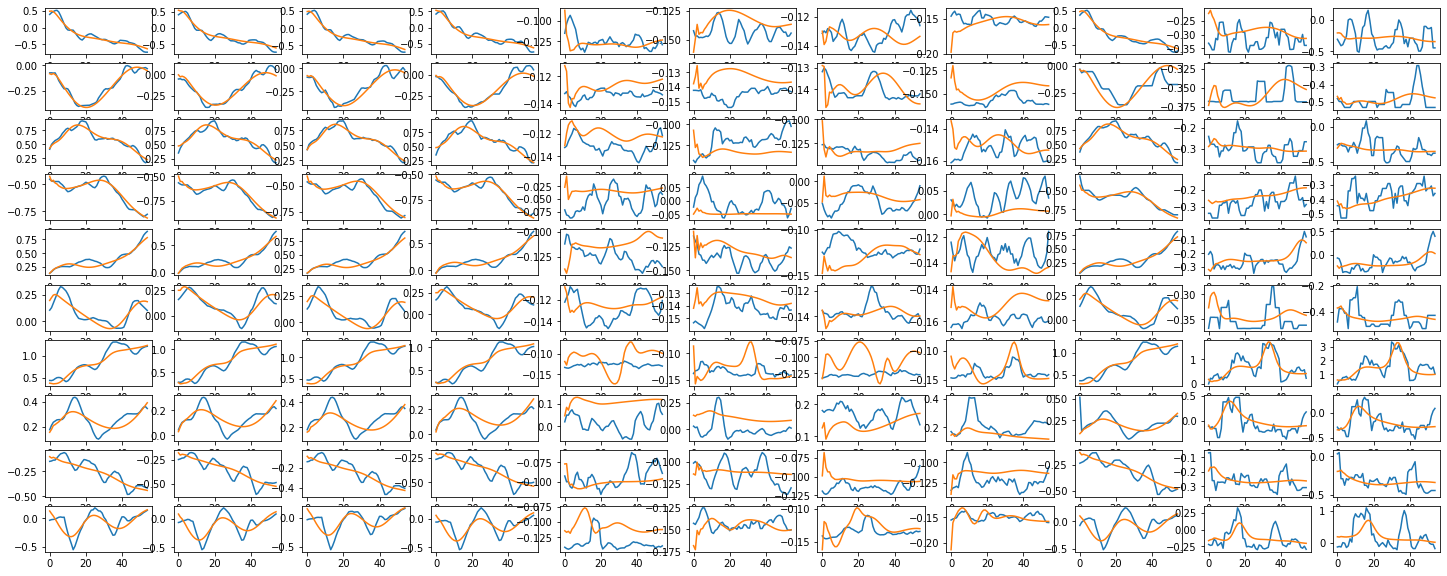

In [9]:
%%time
# sample input vs output to check if the AutoEncoder can reconstruct the input sequence
# test set prediction
import random
test_pred = model.predict(X_test)
sample_ids = random.sample(range(X_test.shape[0]), 10)

fig, axs = plt.subplots(len(sample_ids), X_test.shape[2], figsize=(25,10))
for i in range(len(sample_ids)):
    for c in range(X_test.shape[2]):
        y_true = X_test[sample_ids[i]][:,c]
        y_pred = test_pred[sample_ids[i]][:,c]
        axs[i,c].plot(y_true)
        axs[i,c].plot(y_pred)